In [1]:
using Pkg
Pkg.activate(".")

 Activating environment at `~/code/hypergraph_modularities_code/Project.toml`


In [2]:
using HypergraphModularity
using LinearAlgebra
using Plots
using Printf
using SparseArrays
using StatsBase

In [3]:
function all_or_nothing(p::Vector{Int64})
    is_aon = length(p) == 1
    return (sum(p), is_aon)
end

function polyadic_AON_MLE(Hyp, Z)
    Ω̂ = estimateΩEmpirically(Hyp, Z; min_val=0, aggregator=all_or_nothing)
    ll = Float64(sum(logLikelihood(Hyp, Z, Ω̂; α=0, bigInt=true)))
    return (ll, Ω̂)    
end

function dyadic_MLE(Hyp, Z, weighted::Bool, binary::Bool)
    ω_in, ω_out = 
        computeDyadicResolutionParameter(Hyp, Z; mode="ω", weighted=weighted, binary=binary)
    γ = (ω_in - ω_out) / (log(ω_in) - log(ω_out))
    Q = dyadicModularity(Hyp, Z, γ; weighted=weighted, binary=binary)
    ll = Float64(dyadicLogLikelihood(Hyp, Z, ω_in, ω_out; weighted=weighted, binary=binary))
    return (ll, ω_in, ω_out, γ, Q)
end

dyadic_MLE (generic function with 1 method)

In [4]:
function decomposedDyadicModularity(H, Z, γ, weighted, binary)
    G = CliqueExpansion(H, weighted, binary)
    cluster_ids = unique(Z)
    
    # edge terms
    edges = Dict{Int64, Float64}(c => 0.0 for c in cluster_ids)
    for (i, j, v) in zip(SparseArrays.findnz(G)...)
        if Z[i] == Z[j]
            edges[Z[i]] += v
        end
	end

    # volume terms                                                                                                                                                   
    d = vec(sum(G, dims=1))
    vols = Dict{Int64, Float64}(c => 0.0 for c in cluster_ids)
    for (ci, di) in zip(Z, d)
        vols[ci] += di
    end

    # modularity terms
    volG = sum(d)
    Qs = Dict{Int64, Float64}(c => 0.0 for c in cluster_ids)
    for c in cluster_ids
        Qs[c] = (edges[c] - γ * vols[c]^2 / volG) / volG
    end

    return Qs
end

function decomposedDyadicMLEModularity(H, Z, weighted, binary)
    g_ll, ω_in, ω_out, γ, Q = dyadic_MLE(H, Z, weighted, binary)
    return decomposedDyadicModularity(H, Z, γ, weighted, binary)    
end    

decomposedDyadicMLEModularity (generic function with 1 method)

In [5]:
function decomposedAONPolyadicModularity(H, Z, Ω)
    cluster_ids = unique(Z)
    all_Qs = Dict()
    combined_Qs = Dict{Int64, Float64}(c => 0.0 for c in cluster_ids)
    
    # Volume terms
    vols = Dict{Int64, Float64}(c => 0.0 for c in cluster_ids)
    for (ci, di) in zip(Z, H.D)
        vols[ci] += di
    end
    
    for ℓ = 2:maximum(keys(H.E))
        if haskey(H.E, ℓ)
            # W terms
            Ws = Dict{Int64, Float64}(c => 0.0 for c in cluster_ids)
            for (edge, weight) in H.E[ℓ]
                Zedge = [Z[v] for v in edge]
                if all(z -> z == Zedge[1], Zedge)
                   Ws[Zedge[1]] += weight
                end
            end
            
            # Modularities
            ω1 = Ω.ω((ℓ, true),  0)
            ω0 = Ω.ω((ℓ, false), 0)
            #@show ℓ, ω1, ω0
            α = log(ω1) - log(ω0)
            β = ω1 - ω0
            Qs = Dict{Int64, Float64}(c => 0.0 for c in cluster_ids)
            for c in cluster_ids
                Qs[c] = α * Ws[c] - β * vols[c]^ℓ
                combined_Qs[c] += Qs[c]
            end
            all_Qs[ℓ] = Qs
        end
    end
    
    return all_Qs, combined_Qs
end

function decomposedAONPolyadicMLEModularity(H, Z)
    h_ll, Ω̂ = polyadic_AON_MLE(H, Z)
    return decomposedAONPolyadicModularity(H, Z, Ω̂)[2]
end    

decomposedAONPolyadicMLEModularity (generic function with 1 method)

In [6]:
function dyadic_modularity_contributions(H, labels, names, topk=10, weighted=false, binary=true)
    g_ll, ω_in, ω_out, γ, Q = dyadic_MLE(H, labels, weighted, binary)
    dyadicQs = decomposedDyadicModularity(H, labels, γ, weighted, binary)
    stopind = min(topk, length(names))

    # Dyadic from clique expansion
    println("dyadic...")
    dyadicQ = sort([(name, dyadicQs[i]) for (i, name) in enumerate(names)], by=kv->kv[2], rev=true)[1:stopind]
    for (i, (name, Q)) in enumerate(dyadicQ)
        println(rpad("$i: ", 5), 
                rpad(name, 31),
                rpad(@sprintf("%.3E", Q), 15))
    end
    println("------")
    
    return dyadicQs
end

function polyadic_modularity_contributions(H, labels, names, topk=10, individual=false)
    h_ll, Ω̂ = polyadic_AON_MLE(H, labels)
    Qs, combined_Qs = decomposedAONPolyadicModularity(H, labels, Ω̂)
    stopind = min(topk, length(names))
   
    # Polyadic (combined)
    println("polyadic...")
    polyadicQ = sort([(name, combined_Qs[i]) for (i, name) in enumerate(names)], by=kv->kv[2], rev=true)[1:stopind]
    for (i, (name, Q)) in enumerate(polyadicQ)
        println(rpad("$i: ", 5), 
                rpad(name, 31),
                rpad(@sprintf("%.3E", Q), 15))
    end
    println("------")
    
    if individual
        # Polyadic (per hyperedge size)
        for key in sort(collect(keys(Qs)))
            println("ℓ = $(key)...")
            Qℓ = sort([(name, Qs[key][i]) for (i, name) in enumerate(names)], by=kv->kv[2], rev=true)[1:stopind]
            for (i, (name, Q)) in enumerate(Qℓ)
                println(rpad("$i: ", 5), 
                        rpad(name, 31),
                        rpad(@sprintf("%.3E", Q), 15))
            end
            println("------")
        end
    end
    
    return Qs, combined_Qs
end

polyadic_modularity_contributions (generic function with 3 methods)

In [7]:
function walmart_no_other(min, max)
    dataset = "walmart-trips"
    H, labels = read_hypergraph_data(dataset, max, min)
    names = read_hypergraph_label_names(dataset)

    # throw out "Other" category
    other_key = "Other"
    other_ind = findfirst(names .== other_key)
    keep = Vector{Bool}(labels .!= other_ind)
    (subH, node_map) = subhypergraph(H, keep)
    sub_labels = zeros(Int64, maximum(subH.N))
    for (i, j) in node_map
        sub_labels[j] = labels[i]
    end

    # Just to keep rest of the code the same
    H = subH
    labels = sub_labels
    names = names[names .!= other_key]
    return H, labels, names
end

walmart_no_other (generic function with 1 method)

In [8]:
H, labels, names = walmart_no_other(2, 10)
dyadic_modularity_contributions(H, labels, names, 12)
polyadic_modularity_contributions(H, labels, names, 12)

dyadic...
1:   Food, Household & Pets         9.198E-02      
2:   Pharmacy, Health & Beauty      4.885E-02      
3:   Clothing, Shoes & Accessories  4.247E-02      
4:   Home, Furniture & Appliances   1.378E-02      
5:   Baby                           1.238E-02      
6:   Auto, Tires & Industrial       8.468E-03      
7:   Home Improvement & Patio       6.702E-03      
8:   Electronics and Office         6.170E-03      
9:   Toys, Games, and Video Games   4.499E-03      
10:  Sports, Fitness & Outdoors     3.582E-03      
------
polyadic...
1:   Food, Household & Pets         1.535E+04      
2:   Pharmacy, Health & Beauty      4.611E+03      
3:   Clothing, Shoes & Accessories  4.314E+03      
4:   Home, Furniture & Appliances   1.145E+03      
5:   Baby                           1.014E+03      
6:   Electronics and Office         9.484E+02      
7:   Auto, Tires & Industrial       9.062E+02      
8:   Home Improvement & Patio       5.541E+02      
9:   Toys, Games, and Video Games  

(Dict{Any,Any}(7 => Dict(7 => 2172.5686649540066,9 => 14.460476681099683,4 => 14.460476623778632,10 => 10.845354862822383,2 => 3.615117795816989,3 => 25.305760785032426,8 => 205.72496223194682,5 => 108.45357308173061,6 => -7.225598458701517e-8,1 => 184.35371950554566…),4 => Dict(7 => 1865.7597086324486,9 => 49.949838805358866,4 => 86.86713764112554,10 => 86.83724530009837,2 => 89.01963318454484,3 => 156.14189059563182,8 => 745.173157594578,5 => 132.44905430006705,6 => 39.08769630870407,1 => 733.2655856604678…),9 => Dict(7 => 1754.7385217718893,9 => 4.699885148990217,4 => 9.399770297942304,10 => 9.399770292842934,2 => -2.2111068278456043e-9,3 => 23.499425377464565,8 => 108.0786068839349,5 => 32.89919603919913,6 => -5.002681574846506e-11,1 => 126.89648487175991…),10 => Dict(7 => 1554.5095412248222,9 => -3.931598414035854e-14,4 => 16.313899468004575,10 => 5.437966489118266,2 => 10.87593297858548,3 => 21.751865932424053,8 => 65.25135791373718,5 => 21.751865957188173,6 => -1.261476597930194

In [9]:
for k = 2:5
    H, labels, names = walmart_no_other(k, k)
    println("$k...")
    dyadic_modularity_contributions(H, labels, names)
    polyadic_modularity_contributions(H, labels, names)
end

2...
dyadic...
1:   Food, Household & Pets         1.147E-01      
2:   Clothing, Shoes & Accessories  7.365E-02      
3:   Pharmacy, Health & Beauty      7.350E-02      
4:   Electronics and Office         2.884E-02      
5:   Home, Furniture & Appliances   2.741E-02      
6:   Auto, Tires & Industrial       2.670E-02      
7:   Baby                           1.364E-02      
8:   Toys, Games, and Video Games   1.295E-02      
9:   Home Improvement & Patio       1.148E-02      
10:  Sports, Fitness & Outdoors     8.676E-03      
------
polyadic...
1:   Food, Household & Pets         2.282E+03      
2:   Clothing, Shoes & Accessories  1.466E+03      
3:   Pharmacy, Health & Beauty      1.463E+03      
4:   Electronics and Office         5.740E+02      
5:   Home, Furniture & Appliances   5.454E+02      
6:   Auto, Tires & Industrial       5.314E+02      
7:   Baby                           2.714E+02      
8:   Toys, Games, and Video Games   2.577E+02      
9:   Home Improvement & Patio 

In [10]:
dataset = "congress-bills"
H, labels = read_hypergraph_data(dataset, 10)
names = read_hypergraph_label_names(dataset)
println("Weight-normalized")
dyadic_modularity_contributions(H, labels, names, 2, true, false)
println("Clique-weighted")
dyadic_modularity_contributions(H, labels, names, 2, false, false)
println("binary")
dyadic_modularity_contributions(H, labels, names, 2, false, true)
polyadic_modularity_contributions(H, labels, names, 2, true)

Weight-normalized
dyadic...
1:   1 democrat                     8.075E-02      
2:   2 republican                   7.661E-02      
------
Clique-weighted
dyadic...
1:   1 democrat                     8.530E-02      
2:   2 republican                   8.030E-02      
------
binary
dyadic...
1:   1 democrat                     5.421E-02      
2:   2 republican                   5.247E-02      
------
polyadic...
1:   2 republican                   7.377E+03      
2:   1 democrat                     6.936E+03      
------
ℓ = 2...
1:   2 republican                   3.672E+02      
2:   1 democrat                     2.423E+02      
------
ℓ = 3...
1:   2 republican                   7.628E+02      
2:   1 democrat                     5.250E+02      
------
ℓ = 4...
1:   2 republican                   9.557E+02      
2:   1 democrat                     6.447E+02      
------
ℓ = 5...
1:   2 republican                   8.914E+02      
2:   1 democrat                     8.639E+02      


(Dict{Any,Any}(7 => Dict(2 => 1001.1704062594151,1 => 952.9892408296862),4 => Dict(2 => 955.6666373501655,1 => 644.7262007461909),9 => Dict(2 => 814.0609372629904,1 => 997.4736242016637),10 => Dict(2 => 743.9286515823136,1 => 948.0832797070414),2 => Dict(2 => 367.2300137685211,1 => 242.28501541426795),3 => Dict(2 => 762.7937951119694,1 => 525.0346798144171),5 => Dict(2 => 891.3901977482426,1 => 863.8537251106518),8 => Dict(2 => 979.4714438802442,1 => 835.5255294069951),6 => Dict(2 => 861.4833942866684,1 => 926.2813700021601)), Dict(2 => 7377.19547725053,1 => 6936.2526652330735))

In [11]:
for k in [2, 5, 10]
    H, labels = read_hypergraph_data(dataset, k, k)
    names = read_hypergraph_label_names(dataset)
    println("$k...")
    dyadic_modularity_contributions(H, labels, names)
    polyadic_modularity_contributions(H, labels, names)
end

2...
dyadic...
1:   1 democrat                     5.633E-02      
2:   2 republican                   5.460E-02      
------
polyadic...
1:   1 democrat                     3.260E+02      
2:   2 republican                   3.160E+02      
------
5...
dyadic...
1:   1 democrat                     7.254E-02      
2:   2 republican                   6.960E-02      
------
polyadic...
1:   2 republican                   8.946E+02      
2:   1 democrat                     8.494E+02      
------
10...
dyadic...
1:   1 democrat                     6.999E-02      
2:   2 republican                   6.686E-02      
------
polyadic...
1:   1 democrat                     8.448E+02      
2:   2 republican                   7.131E+02      
------


In [12]:
dataset = "contact-high-school-classes"
H, labels = read_hypergraph_data(dataset, 10)
names = read_hypergraph_label_names(dataset)
dyadic_modularity_contributions(H, labels, names)
polyadic_modularity_contributions(H, labels, names)

dyadic...
1:   PC                             7.081E-02      
2:   2BIO3                          6.188E-02      
3:   PC*                            6.168E-02      
4:   MP*2                           5.143E-02      
5:   2BIO1                          4.961E-02      
6:   MP                             4.897E-02      
7:   2BIO2                          4.532E-02      
8:   PSI*                           4.491E-02      
9:   MP*1                           2.851E-02      
------
polyadic...
1:   PC                             2.652E+03      
2:   2BIO3                          2.487E+03      
3:   PC*                            2.158E+03      
4:   MP*2                           1.873E+03      
5:   MP                             1.675E+03      
6:   2BIO1                          1.597E+03      
7:   2BIO2                          1.553E+03      
8:   PSI*                           1.260E+03      
9:   MP*1                           6.795E+02      
------


(Dict{Any,Any}(4 => Dict(7 => 255.5943410018569,9 => 63.77877341653997,4 => 13.773036449904671,2 => 82.96722940782519,3 => 217.4976497830685,8 => 112.4159642203192,5 => 74.82908926829907,6 => 33.56822181508115,1 => 142.89596082361888),2 => Dict(7 => 1067.1227949482554,9 => 826.4619462847481,4 => 514.1642911767997,2 => 702.6364096793423,3 => 817.1494858951829,8 => 1039.108007737824,5 => 863.9428971437219,6 => 788.0201693331109,1 => 781.0451144626171),3 => Dict(7 => 1304.3548999415602,9 => 784.6438490629341,4 => 151.59156251477177,2 => 767.9588446693281,3 => 1436.2047354343858,8 => 1007.2699774438063,5 => 935.1198435928675,6 => 438.0211021651198,1 => 672.7356376824928),5 => Dict(7 => 25.12139878897186,9 => -0.15748648381414376,4 => -0.004921452619191993,2 => -0.21705469199255595,3 => 16.06037117605954,8 => -0.40345710837759874,5 => -0.4686246097420493,6 => -0.031089166351076464,1 => -0.13591991637700349)), Dict(7 => 2652.1934346806443,9 => 1674.727082280408,4 => 679.5239686888569,2 => 15

In [13]:
dataset = "contact-primary-school-classes"
H, labels = read_hypergraph_data(dataset, 10)
names = read_hypergraph_label_names(dataset)
;

In [14]:
println("Weight-normalized")
dyadic_modularity_contributions(H, labels, names, 12, true, false)
println("Clique-weighted")
dyadic_modularity_contributions(H, labels, names, 12, false, false)
println("binary")
dyadic_modularity_contributions(H, labels, names, 12, false, true)
polyadic_modularity_contributions(H, labels, names, 12)

Weight-normalized
dyadic...
1:   1B                             3.915E-02      
2:   2B                             3.436E-02      
3:   5B                             3.048E-02      
4:   3B                             2.988E-02      
5:   2A                             2.908E-02      
6:   5A                             2.734E-02      
7:   4A                             2.694E-02      
8:   3A                             2.475E-02      
9:   4B                             2.417E-02      
10:  1A                             2.261E-02      
11:  Teachers                       7.414E-04      
------
Clique-weighted
dyadic...
1:   1B                             4.850E-02      
2:   2B                             3.868E-02      
3:   3B                             3.730E-02      
4:   5B                             3.493E-02      
5:   2A                             3.326E-02      
6:   5A                             3.219E-02      
7:   4A                             3.103E-02      
8: 

(Dict{Any,Any}(4 => Dict(2 => 51.42841304851836,11 => 50.52808025917478,7 => 88.77405839740723,9 => 82.11852137933587,10 => 52.14606512419178,8 => 228.41481183250463,6 => 44.17233662310554,4 => -0.07756504664845033,3 => 66.70317085530311,5 => 174.43940934198625…),2 => Dict(2 => 183.3524521350051,11 => 125.50663870486284,7 => 196.0435800913647,9 => 246.1195745389818,10 => 226.0263229379082,8 => 73.49879628659977,6 => 275.4401654445742,4 => 26.92786143755678,3 => 178.84800149416665,5 => 76.47762887688532…),3 => Dict(2 => 870.3286104168769,11 => 695.5434388690398,7 => 922.7779613621788,9 => 997.8964250540589,10 => 665.7609786170443,8 => 1475.0735123417844,6 => 542.8753383193641,4 => 9.295605951573377,3 => 784.1567731280045,5 => 1056.658654747634…),5 => Dict(2 => -0.03926751539013009,11 => -0.13971749051080692,7 => -0.053717329699921636,9 => -0.10016968454683721,10 => -0.03492299963972619,8 => -0.37736431791070607,6 => 6.883186250517218,4 => -0.00011918573937197023,3 => -0.0270581492895333

In [15]:
for k = 2:5
    H, labels = read_hypergraph_data(dataset, k, k)
    names = read_hypergraph_label_names(dataset)
    println("$k...")
    dyadic_modularity_contributions(H, labels, names)
    polyadic_modularity_contributions(H, labels, names)
end

2...
dyadic...
1:   2B                             2.279E-02      
2:   4B                             2.104E-02      
3:   5B                             1.793E-02      
4:   2A                             1.755E-02      
5:   4A                             1.544E-02      
6:   1A                             1.424E-02      
7:   5A                             1.389E-02      
8:   1B                             1.380E-02      
9:   3A                             1.068E-02      
10:  3B                             1.030E-02      
------
polyadic...
1:   2B                             2.684E+02      
2:   4B                             2.478E+02      
3:   5B                             2.112E+02      
4:   2A                             2.067E+02      
5:   4A                             1.819E+02      
6:   1A                             1.677E+02      
7:   5A                             1.636E+02      
8:   1B                             1.625E+02      
9:   3A                       

In [16]:
dataset = "TrivagoClickout"
H, labels = read_hypergraph_data(dataset, 9)
names = read_hypergraph_label_names(dataset)
dyadic_modularity_contributions(H, labels, names, 5)
polyadic_modularity_contributions(H, labels, names, 5, true)

dyadic...
1:   Brazil                         7.353E-02      
2:   Japan                          6.520E-02      
3:   USA                            6.310E-02      
4:   United Kingdom                 4.756E-02      
5:   Germany                        4.161E-02      
------
polyadic...
1:   Brazil                         1.806E+05      
2:   Japan                          1.804E+05      
3:   USA                            1.746E+05      
4:   United Kingdom                 1.332E+05      
5:   Germany                        1.114E+05      
------
ℓ = 3...
1:   Brazil                         8.763E+04      
2:   USA                            7.261E+04      
3:   Japan                          6.903E+04      
4:   United Kingdom                 5.572E+04      
5:   Mexico                         5.067E+04      
------
ℓ = 4...
1:   Brazil                         4.317E+04      
2:   Japan                          4.289E+04      
3:   USA                            4.042E+04      
4: 

(Dict{Any,Any}(7 => Dict(11 => 318.378786709897,134 => -2.317203773901536e-22,158 => -3.7849198862894047e-31,160 => 0.0,29 => 442.1927590377177,131 => -3.1170442779144353e-25,74 => -1.2886991543694512e-21,57 => 689.8207040127342,31 => 2210.961043030723,70 => 17.68771037755178…),4 => Dict(11 => 1631.8263483851408,134 => -8.878121354270701e-11,158 => -8.457286764851681e-16,160 => 0.0,29 => 2019.7910078024163,131 => -2.0305945522408888e-12,74 => -2.3666955855628593e-10,57 => 2008.3619399385182,31 => 7878.297194354285,70 => 45.64601778825238…),9 => Dict(11 => 196.50717703263442,134 => -5.715546425812268e-30,158 => -2.881411006869744e-41,160 => 0.0,29 => 262.00956937666365,131 => -1.1627532737669594e-33,74 => 43.66826156281451,57 => 262.00956937641996,31 => 1048.0382583610003,70 => -1.5644631662441213e-28…),3 => Dict(11 => 3885.7139381494408,134 => 9.388656685267305,158 => -1.1631728803888065e-10,160 => 0.0,29 => 4382.200772770377,131 => -3.989682979733606e-8,74 => 28.165970675656745,57 => 

In [17]:
for k = 5:8
    H, labels = read_hypergraph_data(dataset, k, k)
    println("$k...")
    dyadic_modularity_contributions(H, labels, names, 5)
    polyadic_modularity_contributions(H, labels, names, 5)
end

5...
dyadic...
1:   Brazil                         7.842E-02      
2:   Japan                          7.105E-02      
3:   USA                            6.435E-02      
4:   United Kingdom                 4.975E-02      
5:   Germany                        4.370E-02      
------
polyadic...
1:   Japan                          2.591E+04      
2:   USA                            2.418E+04      
3:   Brazil                         2.376E+04      
4:   United Kingdom                 1.842E+04      
5:   Germany                        1.579E+04      
------
6...
dyadic...
1:   Brazil                         7.491E-02      
2:   Japan                          7.027E-02      
3:   USA                            6.606E-02      
4:   United Kingdom                 4.848E-02      
5:   Turkey                         4.296E-02      
------
polyadic...
1:   Japan                          1.539E+04      
2:   USA                            1.469E+04      
3:   Brazil                         1.429

In [18]:
n1 = 150
n2 = 50
n = n1 + n2
Z = [ones(Int64, n1); 2 * ones(Int64, n2)]
ϑ = dropdims(ones(1,n) + rand(1,n), dims=1)
μ = mean(ϑ)
names = ["group1", "group2"]

kmax = 3
ω1 = 5e-2
ω2 = 1e-2
ω0 = 1e-3
function ω(p, α)
    if length(p) == 1
        return ω1
    else
        return ω0
    end
end

Ω = partitionIntensityFunction(ω,  kmax)
H = sampleSBM(Z, ϑ, Ω; α=1, kmax=kmax, kmin=kmax)

println("Weight-normalized")
dyadic_modularity_contributions(H, Z, names, 2, true, false)
println("Clique-weighted")
dyadic_modularity_contributions(H, Z, names, 2, false, false)
println("binary")
dyadic_modularity_contributions(H, Z, names, 2, false, true)
polyadic_modularity_contributions(H, Z, names, 2, true)

Weight-normalized
dyadic...
1:   group1                         4.772E-01      
2:   group2                         3.649E-02      
------
Clique-weighted
dyadic...
1:   group1                         4.772E-01      
2:   group2                         3.649E-02      
------
binary
dyadic...
1:   group1                         1.146E-03      
2:   group2                         7.555E-04      
------
polyadic...
1:   group1                         6.272E+05      
2:   group2                         4.471E+04      
------
ℓ = 3...
1:   group1                         6.272E+05      
2:   group2                         4.471E+04      
------


(Dict{Any,Any}(3 => Dict(2 => 44711.87545806892,1 => 627181.7344698734)), Dict(2 => 44711.87545806892,1 => 627181.7344698734))

In [19]:
function asymm_sbm(n1, n2, p111, p222, p112, p122)
    E = Dict(3 => Dict())
    n = n1 + n2
    
    for i in 1:n, j in (i + 1):n, k in (j + 1):n
        num_in_1 = sum([i <= n1, j <= n1, k <= n1])
        p = 
            if     num_in_1 == 0; p222
            elseif num_in_1 == 1; p122
            elseif num_in_1 == 2; p112
            else   num_in_1 == 3; p111
            end
                
        if rand() < p
            E[3][[i, j, k]] = 1
        end
    end
    
    H = hypergraph(N = 1:n, E = E)
    HypergraphModularity.computeDegrees!(H)
    return(H)
end

asymm_sbm (generic function with 1 method)

In [20]:
n1 = 100
n2 = 80

p111 = 0.04
p222 = 0.06
p112 = 0.01
p122 = 0.01

Z = [ones(Int64, n1); 2 * ones(Int64, n2)]
H = asymm_sbm(n1, n2, p111, p222, p112, p122)

println("Weight-normalized")
dyadic_modularity_contributions(H, Z, names, 2, true, false)
println("Clique-weighted")
dyadic_modularity_contributions(H, Z, names, 2, false, false)
println("binary")
dyadic_modularity_contributions(H, Z, names, 2, false, true)
polyadic_modularity_contributions(H, Z, names, 2)

Weight-normalized
dyadic...
1:   group1                         1.488E-01      
2:   group2                         1.398E-01      
------
Clique-weighted
dyadic...
1:   group1                         1.488E-01      
2:   group2                         1.398E-01      
------
binary
dyadic...
1:   group1                         2.164E-02      
2:   group2                         2.122E-02      
------
polyadic...
1:   group2                         4.489E+03      
2:   group1                         4.356E+03      
------


(Dict{Any,Any}(3 => Dict(2 => 4489.040223944971,1 => 4356.288130881923)), Dict(2 => 4489.040223944971,1 => 4356.288130881923))

In [25]:
n1 = 100
p111 = 0.04
p222 = 0.06
p112 = 0.01
p122 = 0.01

dyadic_clique_rats = []
dyadic_bin_rats = []
polyadic_rats = []
n2s = collect(50:5:180)
for n2 in n2s
    Z = [ones(Int64, n1); 2 * ones(Int64, n2)]
    H = asymm_sbm(n1, n2, p111, p222, p112, p122)
    
    dyadic_Qs = decomposedDyadicMLEModularity(H, Z, false, false)
    push!(dyadic_clique_rats, dyadic_Qs[2] / sum(values(dyadic_Qs)))
    
    dyadic_Qs = decomposedDyadicMLEModularity(H, Z, false, true)
    push!(dyadic_bin_rats, dyadic_Qs[2] / sum(values(dyadic_Qs)))    
    
    polyadic_Qs = decomposedAONPolyadicMLEModularity(H, Z)
    push!(polyadic_rats, polyadic_Qs[2] / sum(values(polyadic_Qs)))
end

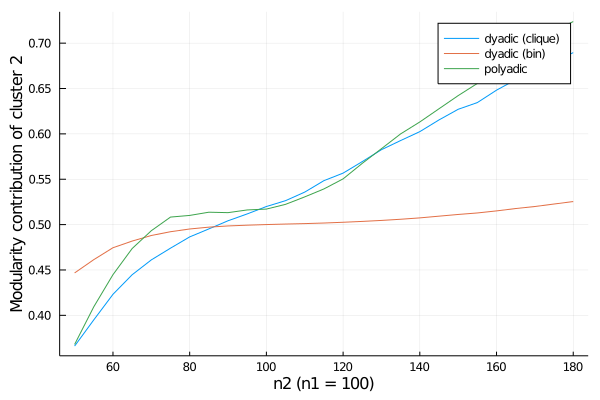

In [26]:
plot(n2s, dyadic_clique_rats, label="dyadic (clique)")
plot!(n2s, dyadic_bin_rats, label="dyadic (bin)")
plot!(n2s, polyadic_rats, label="polyadic")
xlabel!("n2 (n1 = $n1)")
ylabel!("Modularity contribution of cluster 2")

In [27]:
n1 = 100
p111 = 0.05
p222 = 0.05
p112 = 0.015
p122 = 0.01

dyadic_clique_rats = []
dyadic_bin_rats = []
polyadic_rats = []
n2s = collect(50:5:180)
for n2 in n2s
    Z = [ones(Int64, n1); 2 * ones(Int64, n2)]
    H = asymm_sbm(n1, n2, p111, p222, p112, p122)
    
    dyadic_Qs = decomposedDyadicMLEModularity(H, Z, false, false)
    push!(dyadic_clique_rats, dyadic_Qs[2] / sum(values(dyadic_Qs)))
    
    dyadic_Qs = decomposedDyadicMLEModularity(H, Z, false, true)
    push!(dyadic_bin_rats, dyadic_Qs[2] / sum(values(dyadic_Qs)))    
    
    polyadic_Qs = decomposedAONPolyadicMLEModularity(H, Z)
    push!(polyadic_rats, polyadic_Qs[2] / sum(values(polyadic_Qs)))
end

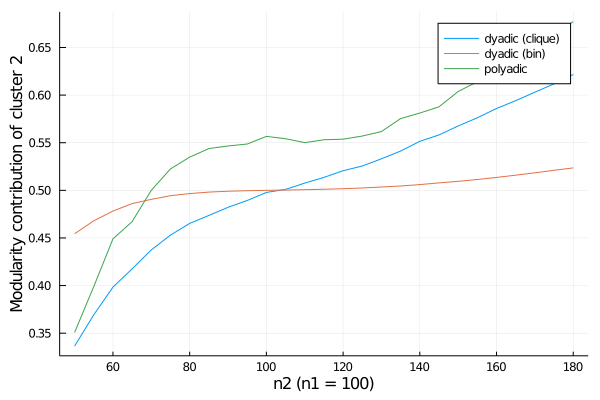

In [28]:
plot(n2s, dyadic_clique_rats, label="dyadic (clique)")
plot!(n2s, dyadic_bin_rats, label="dyadic (bin)")
plot!(n2s, polyadic_rats, label="polyadic")
xlabel!("n2 (n1 = $n1)")
ylabel!("Modularity contribution of cluster 2")